In [1]:
import readdy
import boto3
import numpy as np
import argparse

In [2]:
s3 = boto3.client('s3')
response = s3.download_file('readdy-working-bucket', 'outputs/actin_compression_velocity=15_0.h5', 'actin_compression_velocity=15_0.h5')

In [2]:
cd ..

/home/ec2-user/subcell-analysis


In [5]:
from subcell_analysis.readdy import (
    ReaddyLoader,
    ReaddyPostProcessor,
)

h5_file_path = 'notebooks/actin_compression_velocity=15_0.h5'


post_processor = ReaddyPostProcessor(
    ReaddyLoader(h5_file_path).trajectory(),
    box_size=600.0 * np.ones(3),
)
fiber_chain_ids = post_processor.linear_fiber_chain_ids(
    start_particle_phrases=["pointed"],
    other_particle_types=[
        "actin#",
        "actin#ATP_",
        "actin#mid_",
        "actin#mid_ATP_",
        "actin#fixed_",
        "actin#fixed_ATP_",
        "actin#mid_fixed_",
        "actin#mid_fixed_ATP_",
        "actin#barbed_",
        "actin#barbed_ATP_",
        "actin#fixed_barbed_",
        "actin#fixed_barbed_ATP_",
    ],
    polymer_number_range=5,
)
axis_positions, _ = post_processor.linear_fiber_axis_positions(
    fiber_chain_ids=fiber_chain_ids,
    ideal_positions=np.array(
        [
            [24.738, 20.881, 26.671],
            [27.609, 24.061, 27.598],
            [30.382, 21.190, 25.725],
        ]
    ),
    ideal_vector_to_axis=np.array(
        [-0.01056751, -1.47785105, -0.65833209],
    ),
)
fiber_points = post_processor.linear_fiber_control_points(
    axis_positions=axis_positions,
    segment_length=10.0,
)
print(fiber_points)

Loading ReaDDy data from h5 file...


100%|██████████| 1001/1001 [02:20<00:00,  7.13it/s]


[[array([[-2.47203989e+02,  5.70044402e-03, -2.56005661e-02],
       [-2.37205717e+02,  4.53188412e-03,  6.99727660e-04],
       [-2.27207445e+02, -1.89274984e-02, -3.87293468e-03],
       [-2.17209173e+02, -2.72015319e-03, -1.05247199e-02],
       [-2.07210900e+02, -1.73309899e-03,  1.23593417e-02],
       [-1.97212628e+02, -1.66791367e-02,  5.85304188e-03],
       [-1.87214356e+02,  5.90713190e-03, -7.15024239e-04],
       [-1.77216084e+02,  8.69327433e-03,  2.29848382e-02],
       [-1.67217812e+02, -3.46704900e-03,  4.18229573e-04],
       [-1.57219540e+02,  1.95148689e-02, -7.66573262e-03],
       [-1.47221268e+02,  6.60598642e-03,  6.51824631e-03],
       [-1.37222996e+02, -5.76169423e-03, -1.28721972e-02],
       [-1.27224723e+02,  9.86354865e-03, -1.26455374e-02],
       [-1.17226451e+02, -6.15395083e-03,  4.17826008e-03],
       [-1.07228179e+02, -1.85264462e-02, -1.34975547e-02],
       [-9.72299070e+01,  2.91785402e-03, -6.28372197e-04],
       [-8.72316349e+01, -1.31145834e-

In [6]:
from subcell_analysis.compression_workflow_runner import run_workflow,  plot_metric, plot_metric_list
from subcell_analysis.compression_analysis import (
    COMPRESSIONMETRIC,
)
from subcell_analysis.cytosim.post_process_cytosim import create_dataframes_for_repeats
import pandas as pd


In [7]:
arr = np.array(fiber_points)
arr.shape


def array_to_dataframe(arr):
    # Reshape the array to remove the singleton dimensions
    arr = np.squeeze(arr)

    # Reshape the array to have dimensions (timepoints * 50, 3)
    reshaped_arr = arr.reshape(-1, 3)

    # Create a DataFrame with timepoint and fiber point as multi-index
    timepoints = np.repeat(range(arr.shape[0]), 50)
    fiber_points = np.tile(range(50), arr.shape[0])

    df = pd.DataFrame(reshaped_arr)
    df['time'] = timepoints
    df['id'] = fiber_points

    df.set_index(['time', 'id'], inplace=True)

    return df
df_points = array_to_dataframe(arr)
df_points.reset_index(inplace=True)
df_points.rename(columns= {0:'x', 1:'y', 2:'z'}, inplace=True)
single_timepoint = df_points[df_points['time'] == 0]
single_timepoint

,time,id,x,y,z
0,0,0,-247.203989,0.005700,-0.025601
1,0,1,-237.205717,0.004532,0.000700
2,0,2,-227.207445,-0.018927,-0.003873
3,0,3,-217.209173,-0.002720,-0.010525
4,0,4,-207.210900,-0.001733,0.012359
5,0,5,-197.212628,-0.016679,0.005853
6,0,6,-187.214356,0.005907,-0.000715
7,0,7,-177.216084,0.008693,0.022985
8,0,8,-167.217812,-0.003467,0.000418
9,0,9,-157.219540,0.019515,-0.007666


In [8]:
df_points
df_points['time'].unique()

array([   0,    1,    2, ...,  998,  999, 1000])

In [24]:
df_points[df_points["id"] == 0]


,time,id,x,y,z
0,0,0,-247.203989,0.0057,-0.025601
50,1,0,-247.053989,0.0057,-0.025601
100,2,0,-246.903989,0.0057,-0.025601
150,3,0,-246.753989,0.0057,-0.025601
200,4,0,-246.603989,0.0057,-0.025601
...,...,...,...,...,...
49800,996,0,-97.803989,0.0057,-0.025601
49850,997,0,-97.653989,0.0057,-0.025601
49900,998,0,-97.503989,0.0057,-0.025601
49950,999,0,-97.353989,0.0057,-0.025601


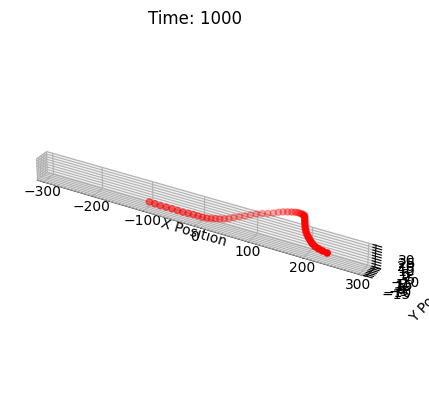

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Assuming you have a DataFrame named 'df_points' with columns 'time', 'id', 'x', 'y', and 'z'
# df_points = pd.DataFrame(...)  # Your data goes here

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get unique timestamps in the data
timestamps = df_points['time'].unique()

# Function to update the plot at each time step
def update_plot(time_step, ax=ax):
    ax.cla()  # Clear previous plot

    # Filter the data for the current timestamp
    data_at_time = df_points[df_points['time'] == timestamps[time_step]]

    # Plot the points at the current time step
    ax.scatter(data_at_time['x'], data_at_time['y'], data_at_time['z'], c='r', marker='o')

    # Set plot labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(f'Time: {timestamps[time_step]}')
    ax.set_xlim([-300, 300])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-10, 30])
    ax.set_aspect("equal")

# Create the animation
# update_plot(-1) 
animation = FuncAnimation(fig, update_plot, frames=len(timestamps), interval=10, repeat=False)
# If you want to save the animation to a file
# animation.save('3d_animation.mp4', writer='ffmpeg')
animation.save('3d_animation_frames/frame_{:04d}.png', writer='pillow', fps=1)

# Show the plot (If you don't want to save it)
plt.show()


In [19]:
%matplotlib inline

In [21]:
plt.close("all")

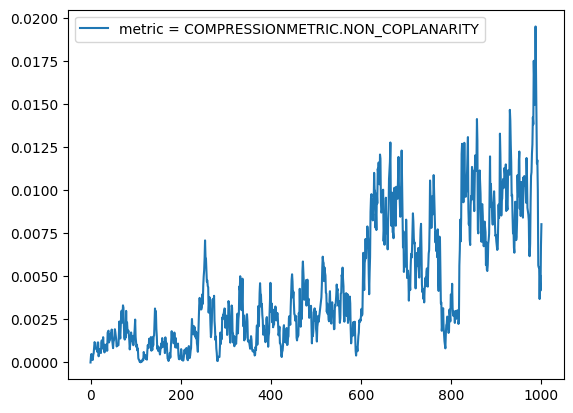

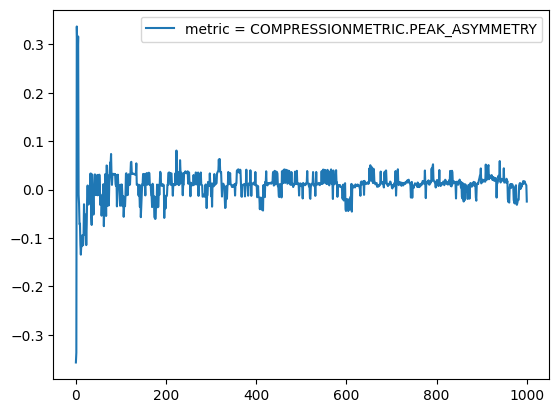

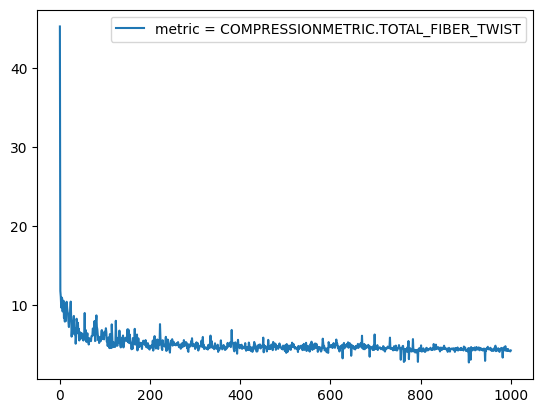

In [28]:
import matplotlib.pyplot as plt
df_pts = array_to_dataframe(arr).reset_index()
df_pts = df_pts.rename(columns={0: 'xpos', 1: 'ypos', 2: 'zpos'})
df_pts
metrics = [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST]
run_workflow(df_pts, [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST])
for metric in metrics:
    fig, ax = plt.subplots()
    metric_by_time = df_pts.groupby(["time"])[metric].mean()
    ax.plot(metric_by_time, label=f"metric = {metric}")
    plt.legend()
    plt.show()
    

In [ ]:
# More Readdy files

